# Name Based Gender Recognition

### Importing all the libraries 

In [1]:
import nltk
import random
import matplotlib.pyplot as plt
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, MaxPooling1D, Conv1D, Dropout,Flatten
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns


### Importing the data - male and female names from nltk library 

In [2]:
nltk.download('names')
from nltk.corpus import names

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.


#Data Preprocessing 








In [3]:
male_names , female_names = names.words('male.txt') , names.words('female.txt')
male_labels , female_labels = ['Male']*len(male_names), ['Female']*len(female_names)

In [4]:
# Joining both the male and females name data and creating labels of all the names in the dataset 
data = male_names + female_names
labels = male_labels + female_labels
print("The length of the data is", len(data), "which comprises of" , len(male_names),"male names and", len(female_names),"female names.")

The length of the data is 7944 which comprises of 2943 male names and 5001 female names.


In [5]:
zipped_data_labels = zip(data, labels)
list_data_labels = list(zipped_data_labels)

#Shuffling the data and labels randomly
random.shuffle(list_data_labels)

data, labels = zip(*list_data_labels)
data, labels  = np.array(data), np.array(labels)

In [6]:
print(data)
print(labels)

['Tammara' 'Phebe' 'Bernelle' ... 'Julianna' 'Kristien' 'Miguel']
['Female' 'Female' 'Female' ... 'Female' 'Female' 'Male']


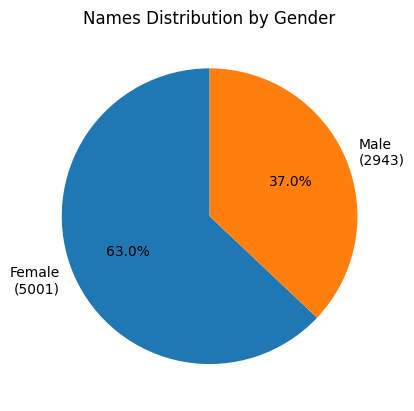

In [7]:
#Creating a visualization plot for the names data
fig, ax = plt.subplots()
lbl, counts = np.unique(labels, return_counts=True)
explode = [0.1] * len(lbl)
percentages = 100 * counts / np.sum(counts)
labels_with_count = [f"{l}\n({c})" for l, c, p in zip(lbl, counts, percentages)]
ax.pie(counts, labels = labels_with_count, autopct = '%1.1f%%', startangle = 90)
ax.set_title('Names Distribution by Gender')
plt.show()

In [8]:
#Creating coded labels where 1 represents male and 0 represents Female
coded_label = [1 if label=="Male" else 0 for label in labels]
labels = np.array(coded_label, dtype = 'float32')

In [9]:
#Converting the data into lower case and splitting the data into characters
data = [list(name.lower()) for name in data]
# data[:20]

In [10]:
#Creating vector representations for words by using word2Vec
size = 50
word2vec = Word2Vec(data , vector_size = size , sg = 1 , min_count = 1, workers = -1)

In [11]:
#Creating vector representations for every character of a word 
word_vector = [[word2vec.wv[character] for character in name] for name in data]

In [12]:
#Padding 
#Padding each character with 0 
max_name_length = 35
padded_data = np.array([(name + [np.zeros(size, dtype='float32')]*(max_name_length-len(name))) for name in word_vector]).astype('float32')

In [13]:
#Splitting the dataset into train and test data 
X_train, X_test, y_train, y_test = train_test_split(padded_data , labels, test_size = 0.20 , stratify = labels , random_state = 42)

### Helper functions to evaluate and plot the model *results*


In [14]:
#Function to evaluate the model
def model_evaluation(y_test, y_pred, accuracy):
    f1 = f1_score(y_test, y_pred, average='binary')
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    cm = confusion_matrix(y_test, y_pred) 
    return {'Precision': precision, 'Recall': recall, 'f1_score': f1, 'Confusion matrix': cm, 'Accuracy' : accuracy}

In [15]:
#Function to display and visualize the results of the model
def model_plot(model_results):
    print('Accuracy :', model_results['Accuracy'][1])
    print('Precision :', model_results['Precision'])
    print('Recall :', model_results['Recall'])
    print('F1_Score :', model_results['f1_score'])
    
    cm = model_results['Confusion matrix']
    ax = plt.subplot()
    sns.heatmap(cm, annot = True, fmt = 'g', ax = ax, cmap = 'YlGnBu')
    ax.set_ylabel('Predicted Labels');
    ax.set_xlabel('True Labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['Male', 'Female'])
    ax.yaxis.set_ticklabels(['Male', 'Female'])
    plt.show()


In [38]:
#Function to compare the models
def compare_models(cnn_results, lstm_results, lstmCnn_results):
    zipped_model_accuracies = zip(cnn_results['Accuracy'], lstm_results['Accuracy'], lstmCnn_results['Accuracy'])
    valuePlot = [val for val in zipped_model_accuracies]
    x=range(len(valuePlot[0]))
    fig,ax=plt.subplots()
    ax.plot(x,valuePlot[0], label='Loss')
    ax.plot(x,valuePlot[1], label='Accuracy')
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(labels=['CNN', 'LSTM', 'LSTM + CNN'])
    ax.set_title('Comparison of accuracy and loss')
    ax.set_xlabel('Approaches')
    ax.legend()
    plt.show()

# MODELS

## CNN


### Creating a CNN model 

In [17]:
#Adding two 1-D layers to the CNN model
model = Sequential()
shape_of_input = X_train.shape[1:]
model.add(Conv1D(128, kernel_size = (3), padding = 'same', input_shape = shape_of_input, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Conv1D(128, kernel_size = (3), padding='same', activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

# Displaying the summary of the CNN model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 35, 128)           19328     
                                                                 
 dropout (Dropout)           (None, 35, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 35, 128)           49280     
                                                                 
 dropout_1 (Dropout)         (None, 35, 128)           0         
                                                                 
 flatten (Flatten)           (None, 4480)              0         
                                                                 
 dense (Dense)               (None, 512)               2294272   
                                                                 
 dense_1 (Dense)             (None, 2)                 1

### Initializing a optimizer, fitting and validating 

In [18]:
#Adam optimizer is being initialized with a learning rate = 0.001
optimizer = Adam(learning_rate = 0.001)

#Fitting of the data by using the testing data for validation
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 64, verbose = 1)

Epoch 1/30
100/100 [==============================] - 22s 196ms/step - loss: 0.8467 - accuracy: 0.6013 - val_loss: 0.6771 - val_accuracy: 0.6293
Epoch 2/30
100/100 [==============================] - 8s 79ms/step - loss: 0.6632 - accuracy: 0.6296 - val_loss: 0.6814 - val_accuracy: 0.6293
Epoch 3/30
100/100 [==============================] - 9s 95ms/step - loss: 0.6682 - accuracy: 0.6277 - val_loss: 0.6638 - val_accuracy: 0.6293
Epoch 4/30
100/100 [==============================] - 9s 95ms/step - loss: 0.6647 - accuracy: 0.6291 - val_loss: 0.6592 - val_accuracy: 0.6293
Epoch 5/30
100/100 [==============================] - 9s 89ms/step - loss: 0.6684 - accuracy: 0.6231 - val_loss: 0.6615 - val_accuracy: 0.6293
Epoch 6/30
100/100 [==============================] - 8s 82ms/step - loss: 0.6624 - accuracy: 0.6296 - val_loss: 0.6622 - val_accuracy: 0.6293
Epoch 7/30
100/100 [==============================] - 10s 103ms/step - loss: 0.6610 - accuracy: 0.6296 - val_loss: 0.6593 - val_accuracy: 0.

In [20]:
#Calculating the evaluation of CNN model
predictions_cnn = model.predict(X_test)
y_pred = np.argmax(predictions_cnn , axis = 1).astype('float32')
cnn_results = model_evaluation(y_test, y_pred, model.evaluate(X_test,y_test))

50/50 [==============================] - 1s 11ms/step - loss: 0.5550 - accuracy: 0.7193


## LSTM

### Creating a LSTM model

In [22]:
#Adding 1 LSTM layer 
model = Sequential()
lstm_inputshape = X_train.shape[1:]
model.add(LSTM(128, input_shape = lstm_inputshape , activation = 'relu'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dense(1))

# Displaying the summary of the LSTM model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               91648     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               66048     
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 158,209
Trainable params: 158,209
Non-trainable params: 0
_________________________________________________________________


### Initializing an optimizer, fitting and validating 

In [23]:
#RMSprop optimizer is being initialized with a learning rate = 0.001
optimizer_lstm = RMSprop(learning_rate=0.001)

#Fitting of the data by using the testing data for validation
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
hisotry = model.fit(X_train,y_train, validation_data = (X_test,y_test), epochs = 30, batch_size = 64, verbose = 1)

Epoch 1/30
100/100 [==============================] - 11s 96ms/step - loss: 0.7298 - accuracy: 0.6217 - val_loss: 0.6676 - val_accuracy: 0.6293
Epoch 2/30
100/100 [==============================] - 9s 92ms/step - loss: 0.6711 - accuracy: 0.6217 - val_loss: 0.6625 - val_accuracy: 0.6293
Epoch 3/30
100/100 [==============================] - 8s 82ms/step - loss: 0.6614 - accuracy: 0.6192 - val_loss: 0.6227 - val_accuracy: 0.6312
Epoch 4/30
100/100 [==============================] - 9s 92ms/step - loss: 0.6457 - accuracy: 0.6338 - val_loss: 0.6368 - val_accuracy: 0.6608
Epoch 5/30
100/100 [==============================] - 9s 94ms/step - loss: 0.6335 - accuracy: 0.6557 - val_loss: 0.6296 - val_accuracy: 0.6362
Epoch 6/30
100/100 [==============================] - 8s 80ms/step - loss: 0.6163 - accuracy: 0.6636 - val_loss: 0.5972 - val_accuracy: 0.7067
Epoch 7/30
100/100 [==============================] - 9s 91ms/step - loss: 0.6128 - accuracy: 0.6673 - val_loss: 0.6020 - val_accuracy: 0.629

In [24]:
#Calculating the evaluation of LSTM model
predictions_lstm = model.predict(X_test)
y_pred = np.where(predictions_lstm > 0.5 , 1., 0.).flatten().astype('float32')
lstm_results = model_evaluation(y_test, y_pred, model.evaluate(X_test, y_test))

50/50 [==============================] - 1s 19ms/step - loss: 0.4978 - accuracy: 0.7495


## LSTM & CNN 

### Creating a LSTM and CNN model 

In [26]:
model=Sequential()
#Adding 1 LSTM Layer
model.add(LSTM(128, input_shape = (X_train.shape[1:]) , activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

#Adding 1 1-D CNN layer 
model.add(Conv1D(128,kernel_size = (3), padding = 'same', activation = 'relu'))
model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dense(2, activation = 'softmax'))

#Displaying the model summary 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 35, 128)           91648     
                                                                 
 dropout_3 (Dropout)         (None, 35, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 35, 128)           49280     
                                                                 
 dropout_4 (Dropout)         (None, 35, 128)           0         
                                                                 
 flatten_2 (Flatten)         (None, 4480)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               2294272   
                                                                 
 dense_5 (Dense)             (None, 2)                

In [27]:
#RMSprop optimizer is being initialized with a learning rate = 0.001
optimizer_lstmCnn = RMSprop(learning_rate=0.001)

#Fitting of the data by using the testing data for validation
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer_lstmCnn, metrics = ['accuracy'])
hisotry = model.fit(X_train,y_train, validation_data = (X_test,y_test), epochs = 30, batch_size = 32, verbose = 1)

Epoch 1/30
199/199 [==============================] - 29s 133ms/step - loss: 0.6466 - accuracy: 0.6386 - val_loss: 0.5727 - val_accuracy: 0.7042
Epoch 2/30
199/199 [==============================] - 24s 119ms/step - loss: 0.5682 - accuracy: 0.7081 - val_loss: 0.5247 - val_accuracy: 0.7413
Epoch 3/30
199/199 [==============================] - 23s 115ms/step - loss: 0.5326 - accuracy: 0.7400 - val_loss: 0.5210 - val_accuracy: 0.7634
Epoch 4/30
199/199 [==============================] - 23s 117ms/step - loss: 0.5117 - accuracy: 0.7539 - val_loss: 0.4788 - val_accuracy: 0.7728
Epoch 5/30
199/199 [==============================] - 22s 110ms/step - loss: 0.5048 - accuracy: 0.7564 - val_loss: 0.4880 - val_accuracy: 0.7640
Epoch 6/30
199/199 [==============================] - 24s 121ms/step - loss: 0.4969 - accuracy: 0.7637 - val_loss: 0.4791 - val_accuracy: 0.7741
Epoch 7/30
199/199 [==============================] - 24s 122ms/step - loss: 0.4841 - accuracy: 0.7690 - val_loss: 0.4485 - val_ac

In [28]:
#Calculating the evaluation of LSTM & CNN model
predictions_combined = model.predict(X_test)
y_pred = np.argmax(predictions_combined , axis = 1).astype('float32')
lstmCnn_results = model_evaluation(y_test, y_pred, model.evaluate(X_test,y_test))

50/50 [==============================] - 2s 37ms/step - loss: 0.3650 - accuracy: 0.8332


# RESULTS

### CNN 

Accuracy : 0.7193203568458557
Precision : 0.7457044673539519
Recall : 0.3684210526315789
F1_Score : 0.4931818181818181


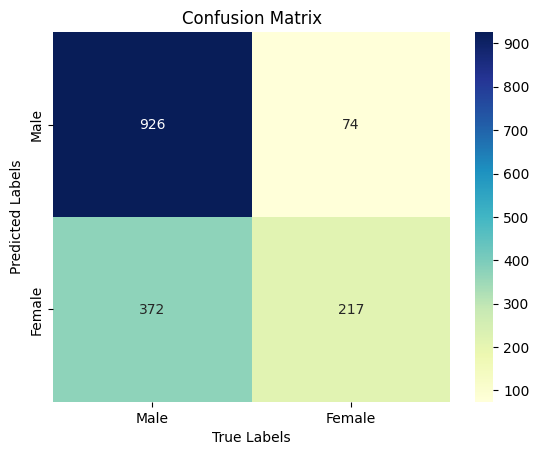

In [29]:
model_plot(cnn_results)

### LSTM



Accuracy : 0.7495279908180237
Precision : 0.6146458583433373
Recall : 0.8692699490662139
F1_Score : 0.7201125175808719


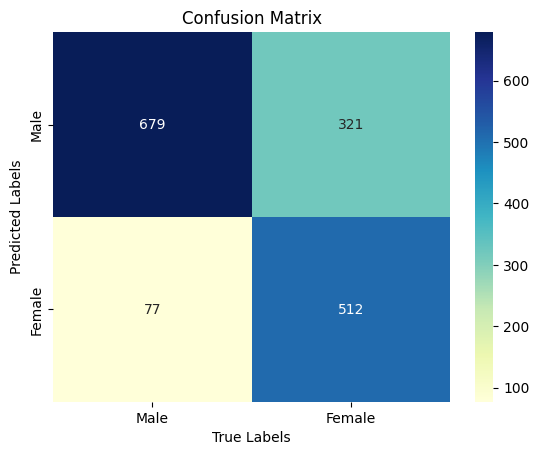

In [30]:
model_plot(lstm_results)

### LSTM & CNN

Accuracy : 0.8332284688949585
Precision : 0.7773972602739726
Recall : 0.7707979626485568
F1_Score : 0.774083546462063


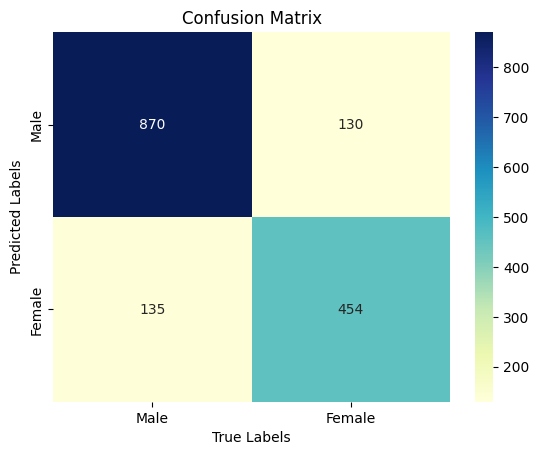

In [31]:
model_plot(lstmCnn_results)

### COMPARISON OF THE RESULTS 

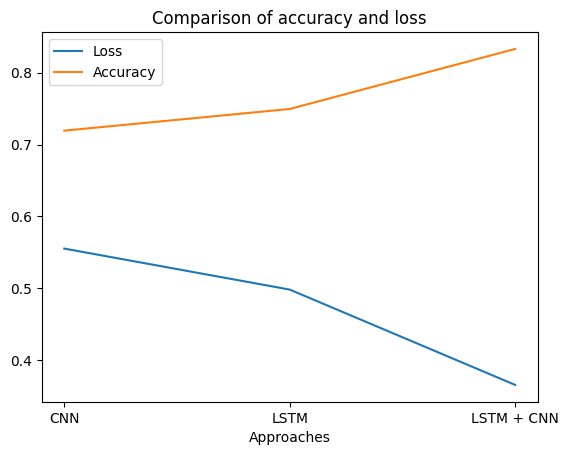

In [39]:
compare_models(cnn_results, lstm_results, lstmCnn_results)
zipped_model_accuracies = zip(cnn_results['Accuracy'], lstm_results['Accuracy'], lstmCnn_results['Accuracy'])

# TESTING OF THE TRAINED MODELS 

In [36]:
choice = 'y'
while (choice == 'y'):
    name = input('Enter a name to test: ')
    name = name.lower()
    chars = list(name)
    wordVec = [word2vec.wv[ch] for ch in chars]
    max_length=35
    padded_data=[(wordVec + [np.zeros(size,dtype='float32')]*(max_length-len(wordVec)))]
    padded_data=np.array(padded_data).astype('float32')
    padded_data.shape
    pred=model.predict(padded_data)
    classes_x=np.argmax(pred,axis=1)
    print('Female' if not classes_x else 'Male')
    print('Probability: ',max(pred[0]))
    choice=input('Do you want to enter more names?(y/n)')
    choice=choice.lower()

Enter a name to test: anjani
1/1 [==============================] - 0s 44ms/step
Female
Probability:  0.8945634
Do you want to enter more names?(y/n)y
Enter a name to test: Shivali
1/1 [==============================] - 0s 34ms/step
Male
Probability:  0.9385098
Do you want to enter more names?(y/n)y
Enter a name to test: Harsh
1/1 [==============================] - 0s 27ms/step
Male
Probability:  0.9712712
Do you want to enter more names?(y/n)y
Enter a name to test: Lax
1/1 [==============================] - 0s 27ms/step
Male
Probability:  0.5024582
Do you want to enter more names?(y/n)y
Enter a name to test: john
1/1 [==============================] - 0s 41ms/step
Male
Probability:  0.9007669
Do you want to enter more names?(y/n)n
